In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import docx
from textblob import TextBlob


plt.style.use('ggplot')


In [5]:
#so i am going to get all text and save to a csv, but first i am cleaning it up, 
doc = docx.Document('Files\\bitcoinData.docx')
# Initialize a list to store all paragraphs
data = []
for word in doc.paragraphs:
    if word.text.strip(): #this is getting rid of whitespace
        data.append([word.text])# here I am appending, adding the clean words/paragraphs to the list

#now i am creating the dataFrame to store it and get it ready to put in a csv
df = pd.DataFrame(data, columns=['text'])

#now i can save it to a csv
df.to_csv('Files\\data_text.csv', index=False)

#print so we know it worked, i will add try and except later
print("All document text has been saved to CSV.")

All document text has been saved to CSV.


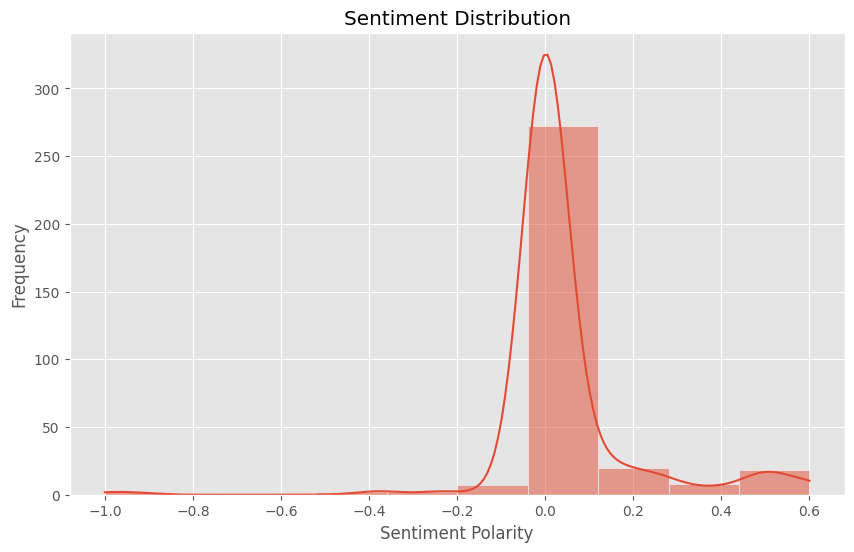

Average sentiment: 0.04


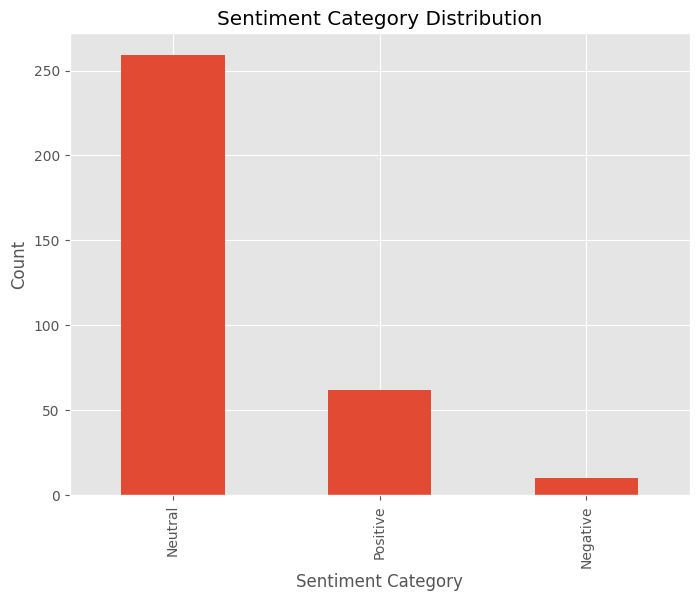

In [6]:
# Load the CSV file
df = pd.read_csv('Files\\data_text.csv')

# Ensure text is in the correct format
df['text'] = df['text'].astype(str)

# Perform sentiment analysis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['text'].apply(get_sentiment)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Calculate and display average sentiment
average_sentiment = df['sentiment'].mean()
print(f"Average sentiment: {average_sentiment:.2f}")

# Categorize sentiments
def categorize_sentiment(polarity):
    if polarity > 0.05:
        return 'Positive'
    elif polarity < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment'].apply(categorize_sentiment)

# Display sentiment category distribution
sentiment_counts = df['sentiment_category'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()
